# IRAT vs. Enet Comparison

For each IRAT strain:
1. Look at all human strains within one year of IRAT assessment (`data/human/irat/<virus_name>.csv`)
2. For each HA subtype (in the HA column) with $\geq 15$ sequences:
    1. Construct an Enet with those HA sequences, including the IRAT strain (capped at 10k sequences)
    2. For all unique sequences, find the E-distance between that sequence and the IRAT sequence under the Enet
    3. Save results: `results/<virus_name>/<subtype>.csv`
3. Repeat step 2 for NA
4. Take the minimum E-distance across all subtypes for both HA and NA
5. Save results: `results/irat.csv`

    
### Running Processes

Computations are done in:
- `irat_predictions.py`
- `run_irat_predictions.sh`

To run, navigate to terminal and do

`chmod ugo+rwx run_irat_predictions.sh`

`./run_irat_predictions.sh`

In [7]:
import os, joblib
import numpy as np
import pandas as pd
from scipy.stats import linregress, pearsonr, t
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 300
import warnings
warnings.filterwarnings('ignore')


RESULT_DIR = 'results/'
LINEAR_MODEL_DIR = 'linear_models/'
EMERGENET_MODEL_DIR = '../emergenet/models/'

# Create the directories if they don't exist
os.makedirs(RESULT_DIR, exist_ok=True)
os.makedirs(LINEAR_MODEL_DIR, exist_ok=True)
os.makedirs(EMERGENET_MODEL_DIR, exist_ok=True)

## Risk Evaluation

For each IRAT strain (except `A/duck/New York/1996`, which does not have an HA available):
1. Take the minimum E-distance across all subtypes for both HA and NA
2. Save these into `HA Risk` and `NA Risk` and compute their geometric mean
3. Save results: `results/irat_predictions/irat.csv`

In [3]:
# IRAT, drop duck strain
irat = pd.read_csv('data/animal/irat.csv')
irat = irat.drop(22).reset_index(drop=True)

# HA risks
risks_ha = {'H1':[], 'H3':[], 'H5':[], 'H7':[], 'H9':[]}
irat_ha = pd.DataFrame()
irat_ha['Influenza Virus'] = irat['Influenza Virus']
for i in range(len(irat)):
    row = irat.iloc[i]
    virus_name = row['Influenza Virus'].replace('/',':')
    DIR = RESULT_DIR + virus_name + '/'
    for k in risks_ha:
        RISK_DIR = DIR + k + '.csv'
        if os.path.exists(RISK_DIR) and os.path.isfile(RISK_DIR):
            df = pd.read_csv(RISK_DIR).sort_values(by='risk')
            min_risk = np.mean(df['risk'][:1])
            risks_ha[k].append(min_risk)
        else:
            risks_ha[k].append(1)
for k in risks_ha:
    irat_ha[k] = risks_ha[k]

# NA risks
risks_na = {'N1':[], 'N2':[], 'N9':[]}
irat_na = pd.DataFrame()
irat_na['Influenza Virus'] = irat['Influenza Virus']
for i in range(len(irat)):
    row = irat.iloc[i]
    virus_name = row['Influenza Virus'].replace('/',':')
    DIR = RESULT_DIR + virus_name + '/'
    for k in risks_na:
        RISK_DIR = DIR + k + '.csv'
        if os.path.exists(RISK_DIR) and os.path.isfile(RISK_DIR):
            df = pd.read_csv(RISK_DIR).sort_values(by='risk')
            min_risk = np.mean(df['risk'][:1])
            risks_na[k].append(min_risk)
        else:
            risks_na[k].append(1)
for k in risks_na:
    irat_na[k] = risks_na[k]

# Add to IRAT
irat['HA Risk'] = irat_ha[['H1', 'H3', 'H5', 'H7', 'H9']].min(axis=1) + 1e-5
irat['NA Risk'] = irat_na[['N1', 'N2', 'N9']].min(axis=1) + 1e-5
irat['Geom Mean Risk'] = np.sqrt(irat['HA Risk'] * irat['NA Risk'])
irat = irat.sort_values(by='Geom Mean Risk').reset_index(drop=True)
# irat.to_csv(RESULT_DIR + 'irat.csv', index=False,float_format='%1.5f')
irat.columns

Index(['Influenza Virus', 'Virus Type', 'Date of Risk Assessment',
       'Risk Score Category', 'Emergence Score', 'Impact Score',
       'Mean Low Acceptable Emergence', 'Mean High Acceptable Emergence',
       'Mean Low Acceptable Impact', 'Mean High Acceptable Impact',
       'HA Sequence', 'NA Sequence', 'HA Length', 'NA Length', 'HA Risk',
       'NA Risk', 'Geom Mean Risk'],
      dtype='object')

## Plots

In [8]:
def TLS(X, Y):
    A = np.vstack([X, Y]).T
    mean_X = np.mean(X)
    mean_Y = np.mean(Y)
    A_centered = A - np.array([mean_X, mean_Y])
    U, S, Vt = np.linalg.svd(A_centered, full_matrices=False)
    tls_direction = Vt[0, :]
    tls_slope = tls_direction[1] / tls_direction[0]
    tls_intercept = mean_Y - (tls_direction[1] / tls_direction[0]) * mean_X
    tls_Y_pred = tls_slope * X + tls_intercept
    tls_R, _ = pearsonr(tls_Y_pred, Y)
    # p-values
    n = len(X)
    df = n - 2
    t_statistic = tls_R * np.sqrt(df / (1 - tls_R**2))
    tls_p = 2 * (1 - t.cdf(abs(t_statistic), df=df))
    return tls_slope, tls_intercept, tls_R, tls_p

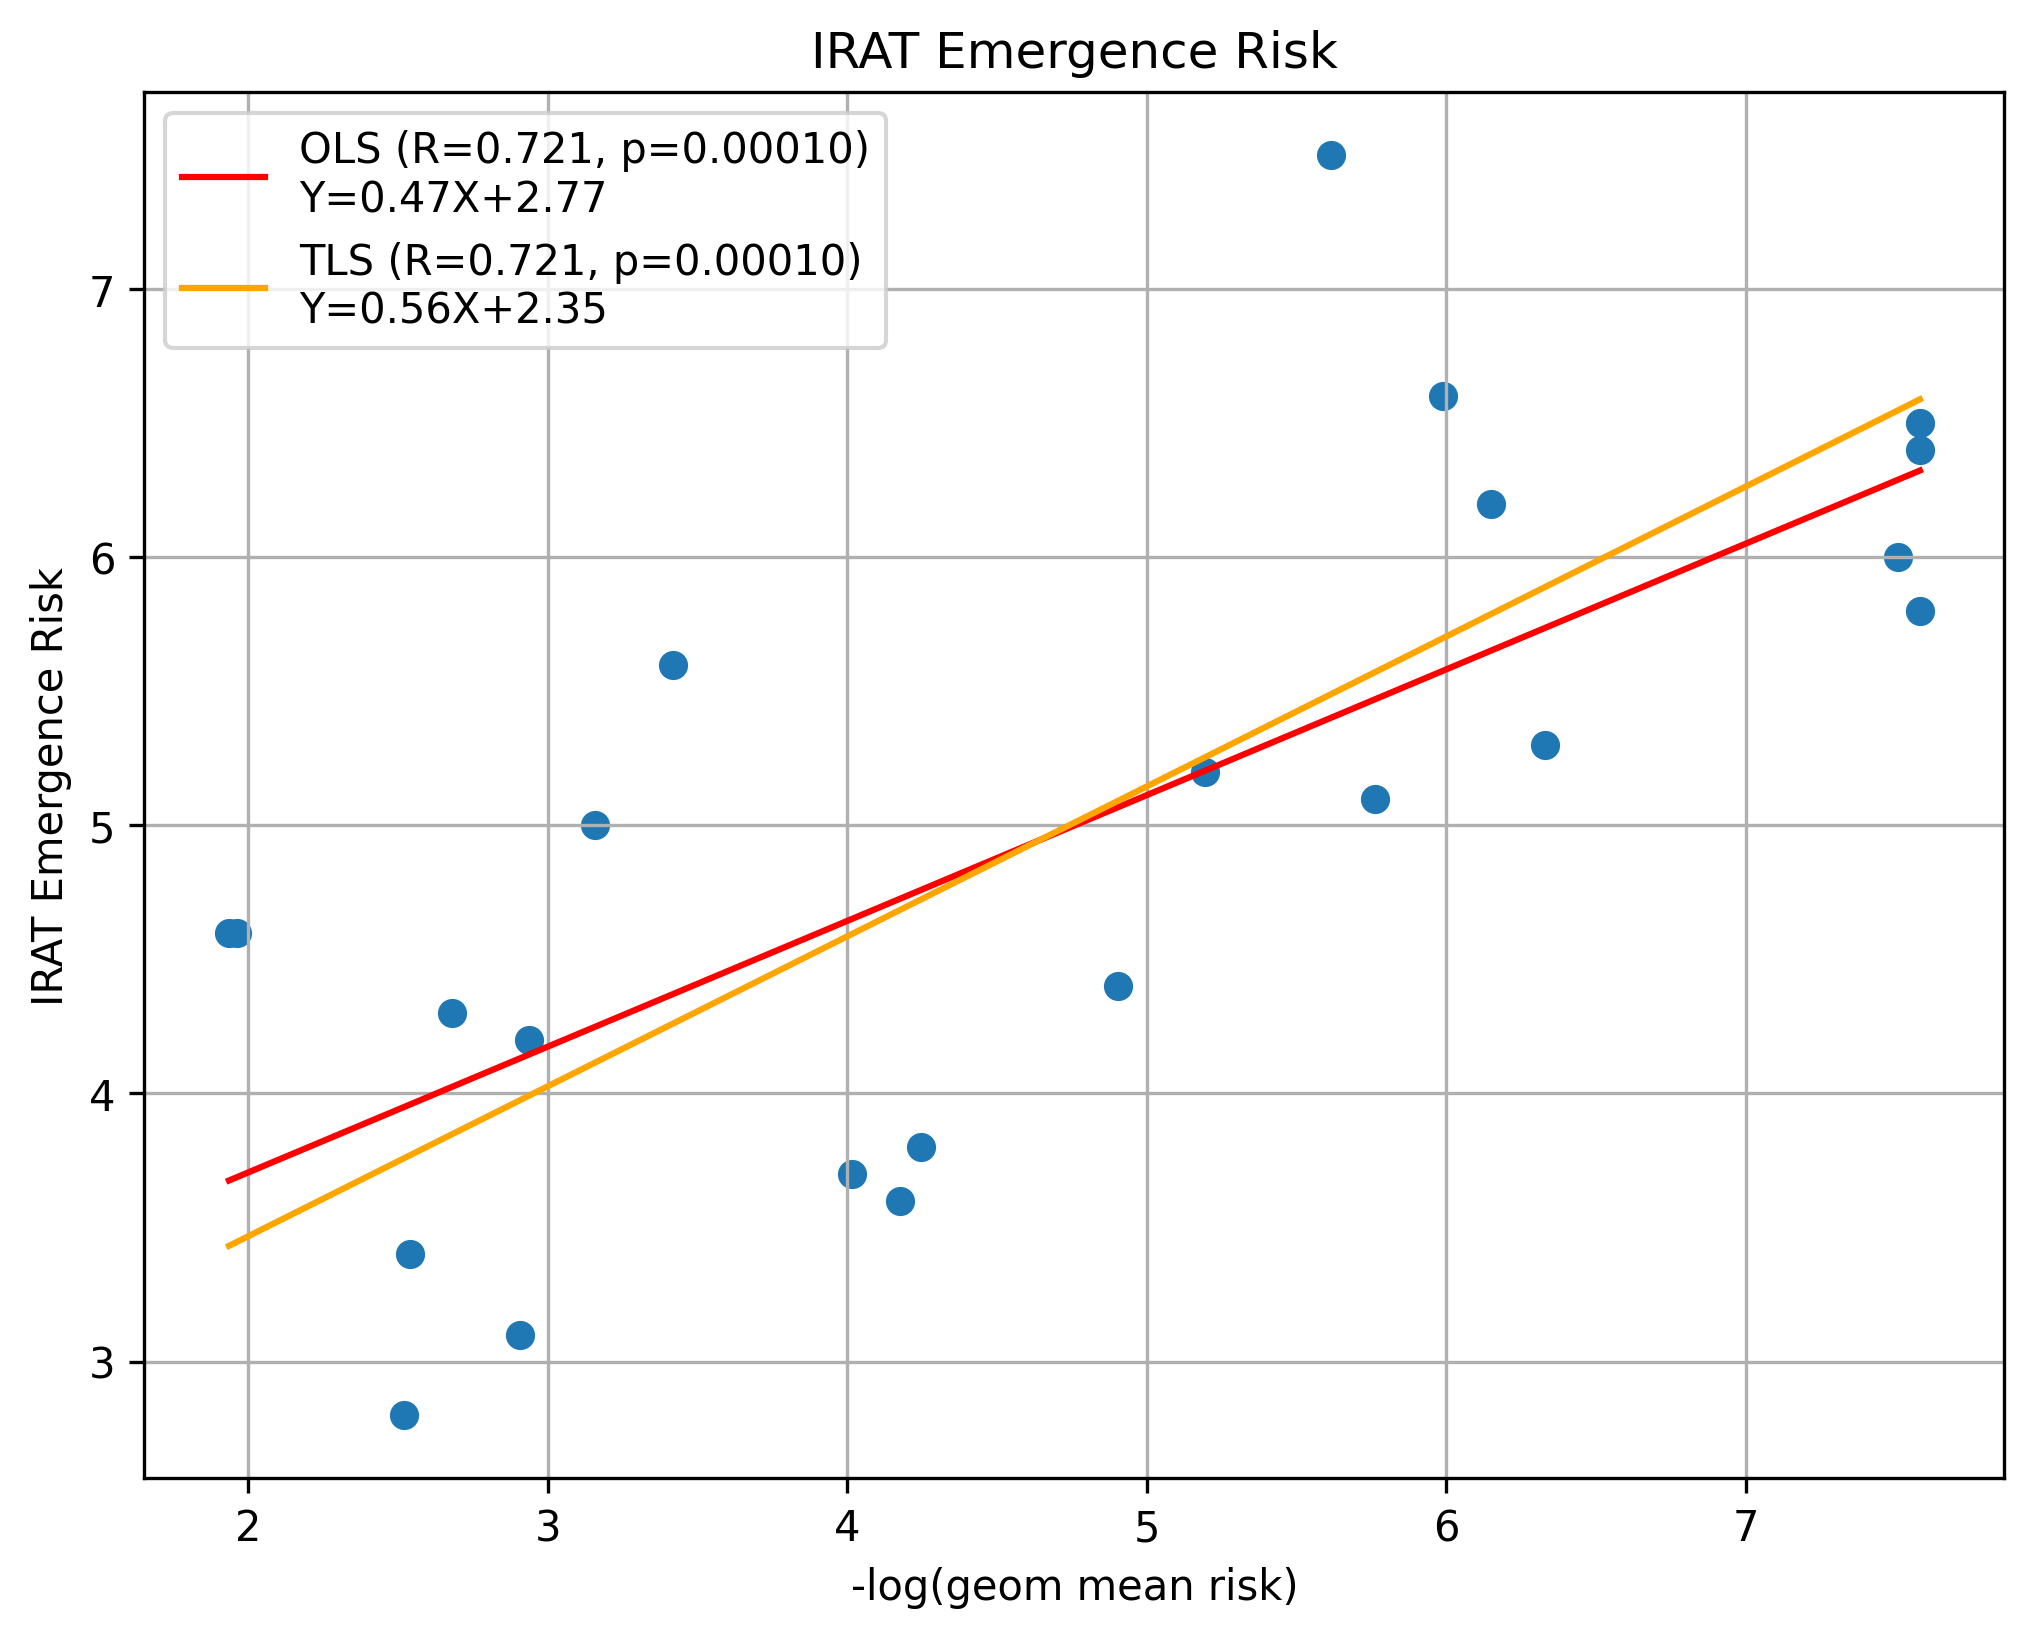

In [9]:
X = -np.log(irat['Geom Mean Risk'] + 5e-4)
Y = irat['Emergence Score']
ols_slope, ols_intercept, ols_R, ols_p, _ = linregress(X, Y)
tls_slope, tls_intercept, tls_R, tls_p = TLS(X, Y)

# Plot
X_line = np.linspace(min(X), max(X), 100)
Y_ols = ols_slope * X_line + ols_intercept
Y_tls = tls_slope * X_line + tls_intercept

plt.scatter(X, Y)
plt.plot(X_line, Y_ols, label=f'OLS (R={ols_R:.3f}, p={ols_p:.5f})\nY={ols_slope:.2f}X+{ols_intercept:.2f}',color='red')
plt.plot(X_line, Y_tls, label=f'TLS (R={tls_R:.3f}, p={tls_p:.5f})\nY={tls_slope:.2f}X+{tls_intercept:.2f}',color='orange')
plt.xlabel('-log(geom mean risk)')
plt.ylabel('IRAT Emergence Risk')
plt.legend()
plt.grid()
plt.title('IRAT Emergence Risk');

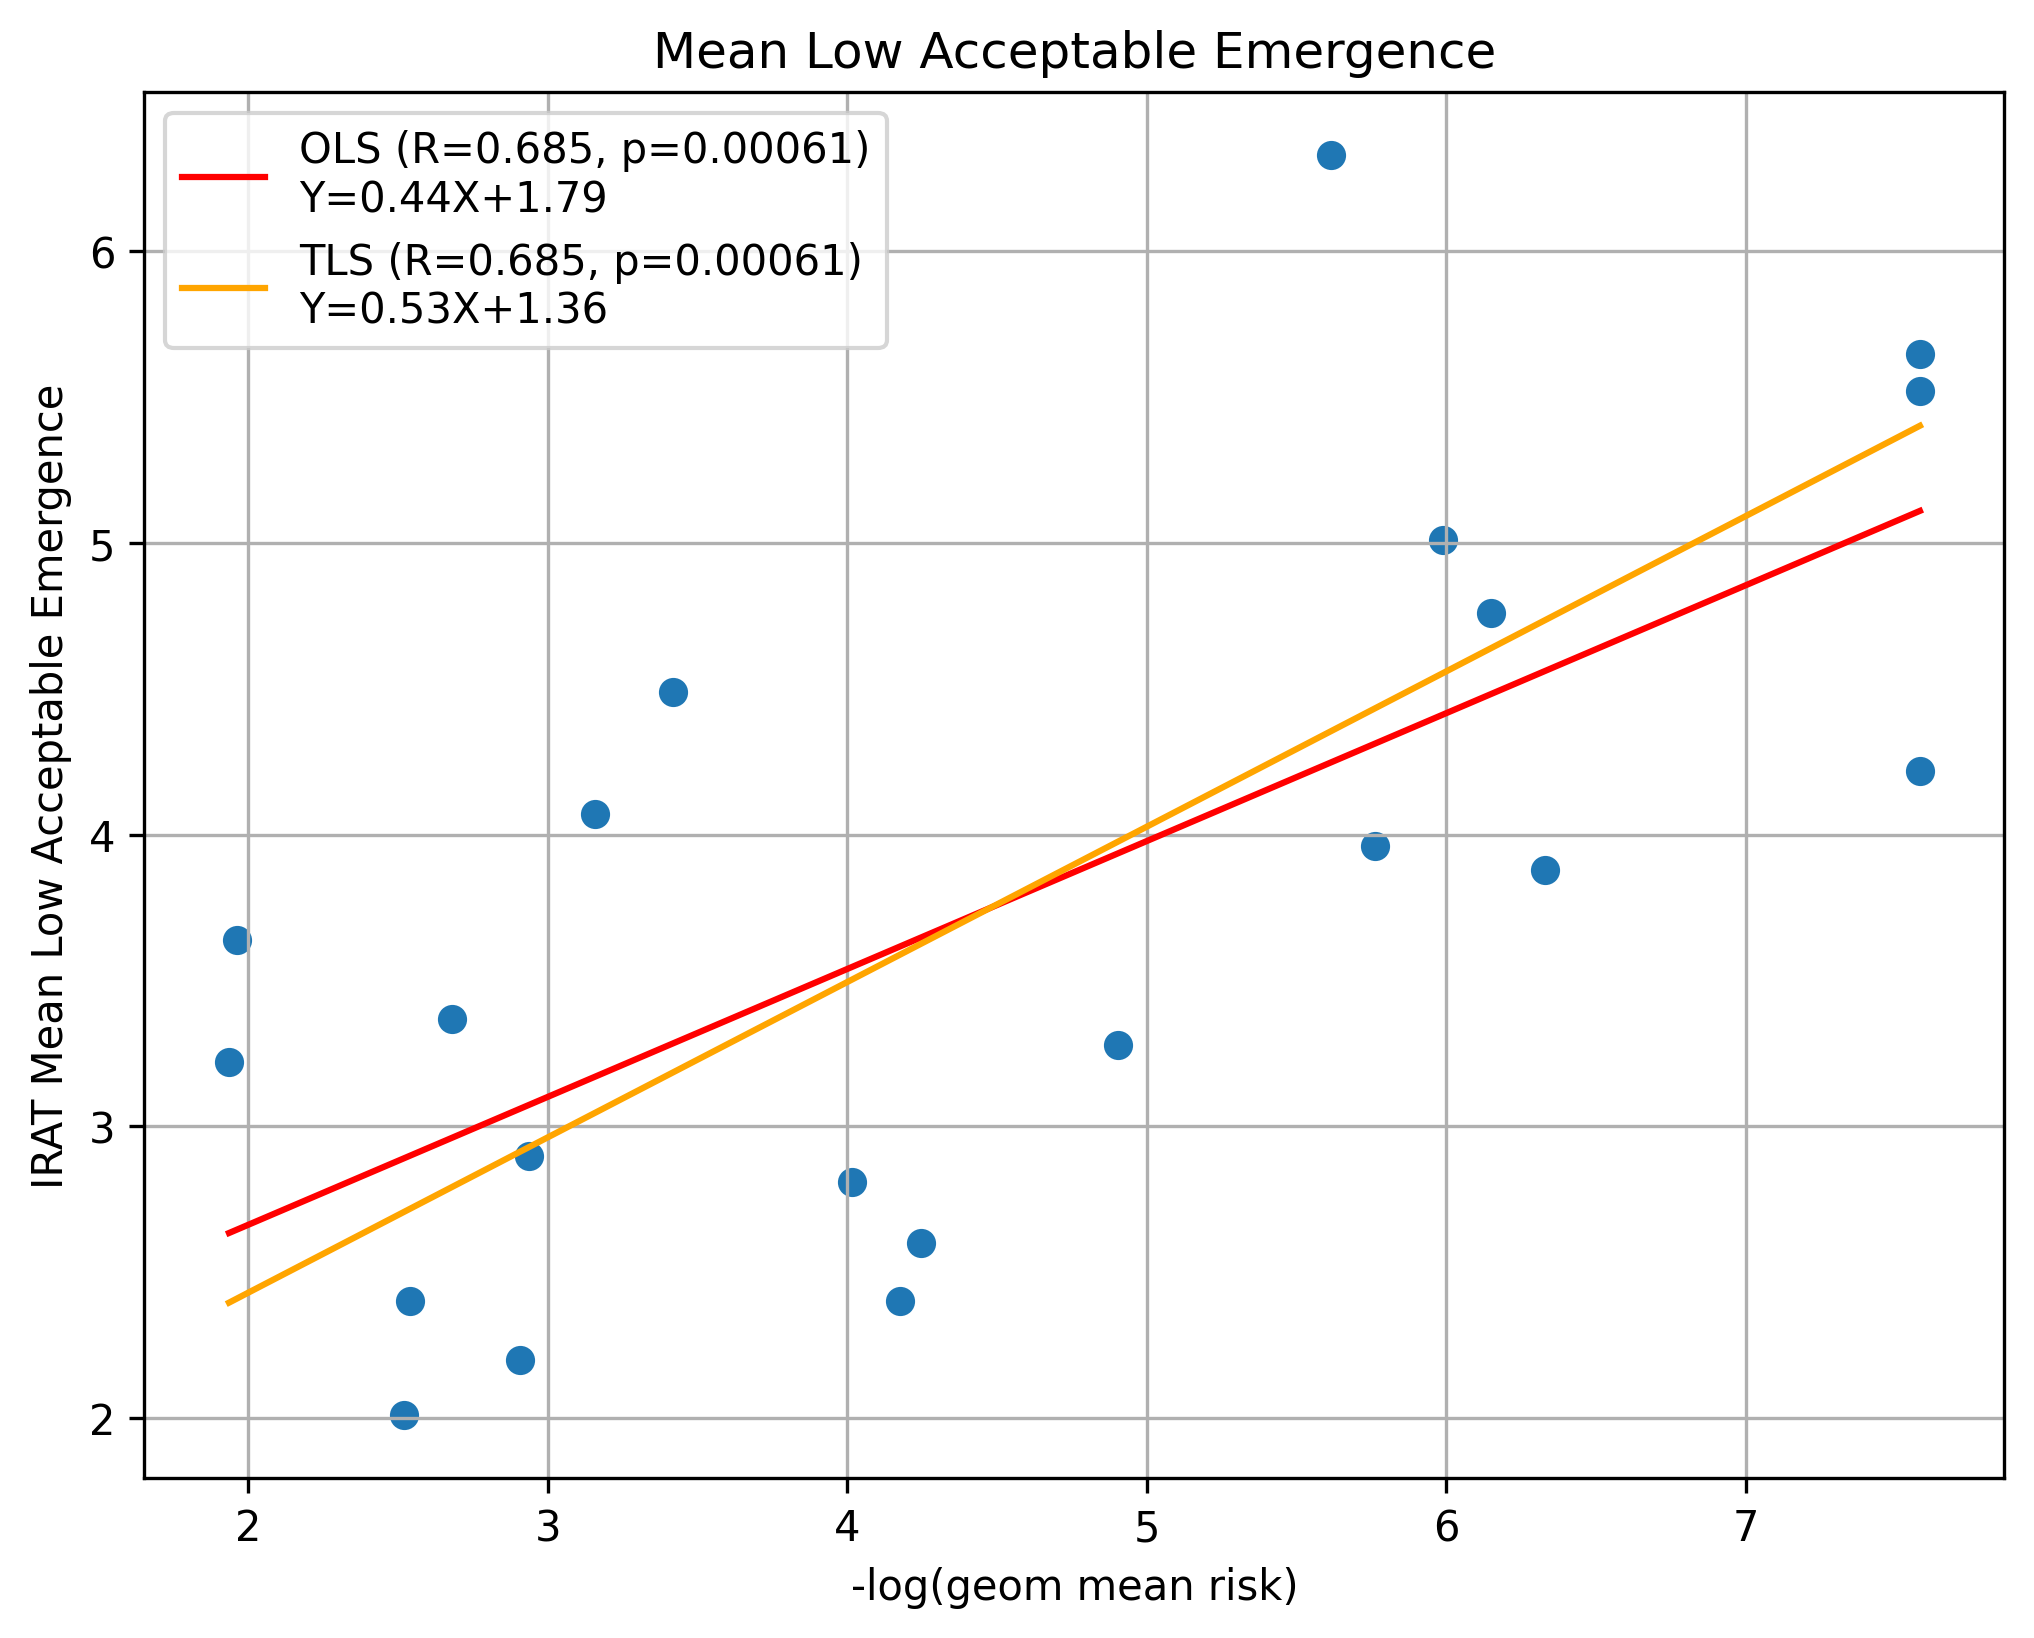

In [10]:
X = (-np.log(irat[irat['Mean Low Acceptable Emergence'] != -1]['Geom Mean Risk'] + 5e-4))
Y = irat[irat['Mean Low Acceptable Emergence'] != -1]['Mean Low Acceptable Emergence']
ols_slope, ols_intercept, ols_R, ols_p, _ = linregress(X, Y)
tls_slope, tls_intercept, tls_R, tls_p = TLS(X, Y)

# Plot
X_line = np.linspace(min(X), max(X), 100)
Y_ols = ols_slope * X_line + ols_intercept
Y_tls = tls_slope * X_line + tls_intercept

plt.scatter(X, Y)
plt.plot(X_line, Y_ols, label=f'OLS (R={ols_R:.3f}, p={ols_p:.5f})\nY={ols_slope:.2f}X+{ols_intercept:.2f}',color='red')
plt.plot(X_line, Y_tls, label=f'TLS (R={tls_R:.3f}, p={tls_p:.5f})\nY={tls_slope:.2f}X+{tls_intercept:.2f}',color='orange')
plt.xlabel('-log(geom mean risk)')
plt.ylabel('IRAT Mean Low Acceptable Emergence')
plt.legend()
plt.grid()
plt.title('Mean Low Acceptable Emergence');

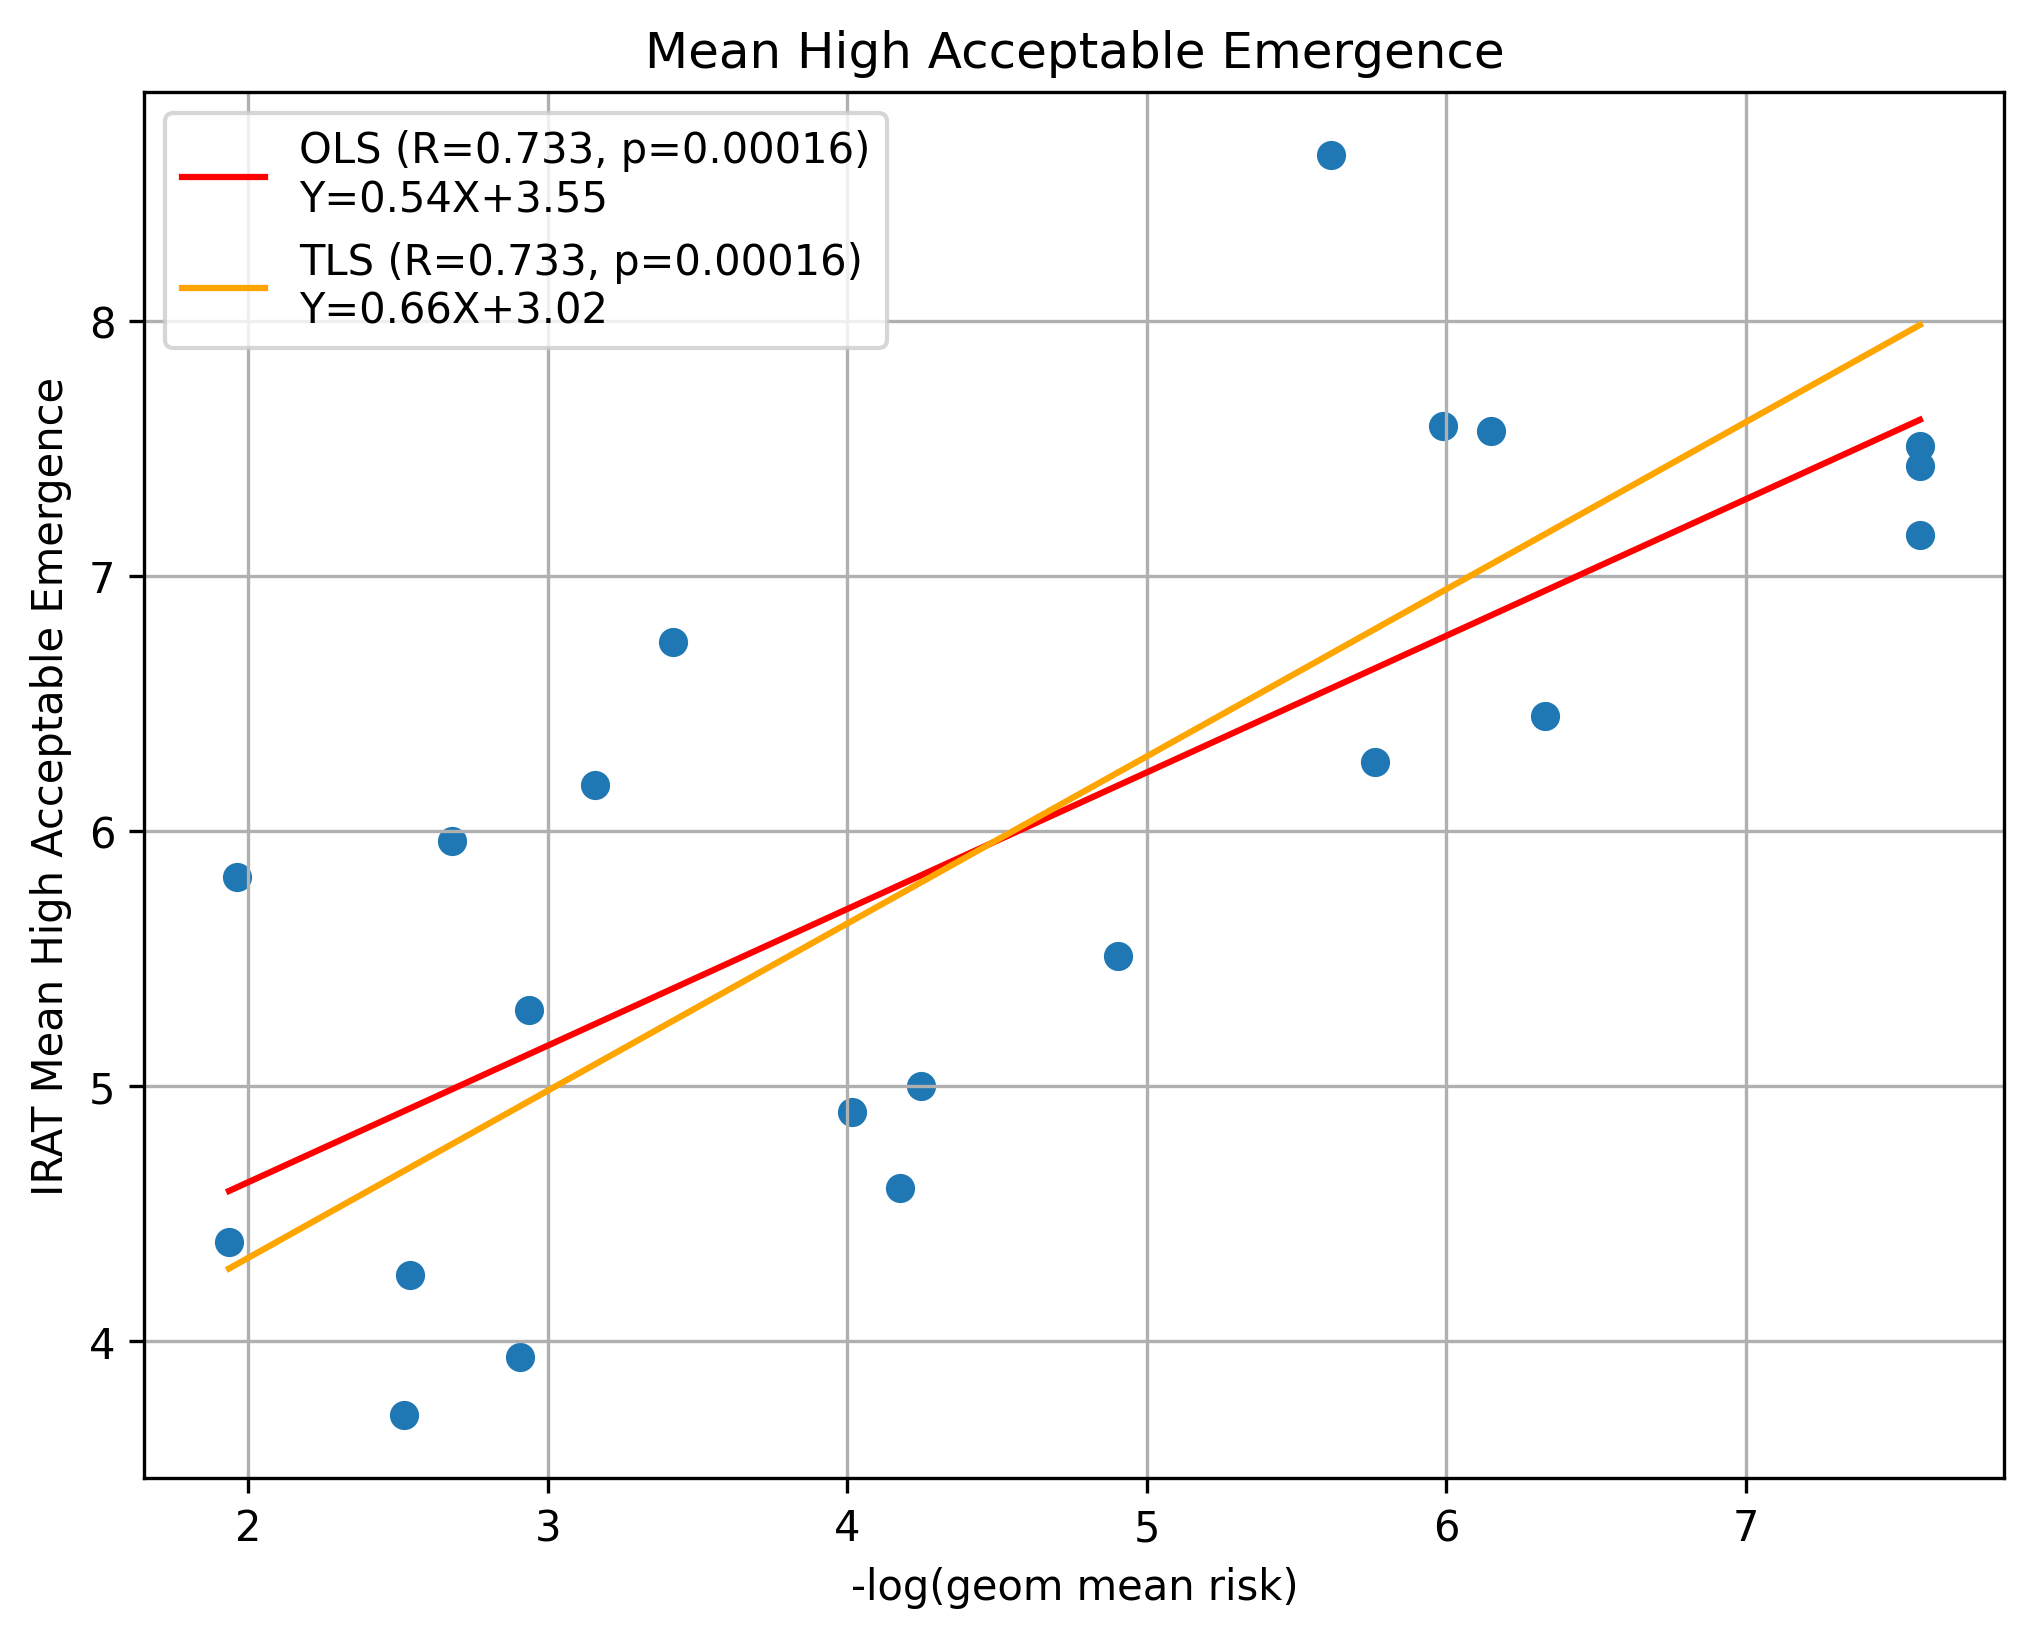

In [11]:
X = (-np.log(irat[irat['Mean High Acceptable Emergence'] != -1]['Geom Mean Risk'] + 5e-4))
Y = irat[irat['Mean High Acceptable Emergence'] != -1]['Mean High Acceptable Emergence']
ols_slope, ols_intercept, ols_R, ols_p, _ = linregress(X, Y)
tls_slope, tls_intercept, tls_R, tls_p = TLS(X, Y)

# Plot
X_line = np.linspace(min(X), max(X), 100)
Y_ols = ols_slope * X_line + ols_intercept
Y_tls = tls_slope * X_line + tls_intercept

plt.scatter(X, Y)
plt.plot(X_line, Y_ols, label=f'OLS (R={ols_R:.3f}, p={ols_p:.5f})\nY={ols_slope:.2f}X+{ols_intercept:.2f}',color='red')
plt.plot(X_line, Y_tls, label=f'TLS (R={tls_R:.3f}, p={tls_p:.5f})\nY={tls_slope:.2f}X+{tls_intercept:.2f}',color='orange')
plt.xlabel('-log(geom mean risk)')
plt.ylabel('IRAT Mean High Acceptable Emergence')
plt.legend()
plt.grid()
plt.title('Mean High Acceptable Emergence');

## Final Model

- Drop outliers (we predicted much lower than IRAT)
    - A/Astrakhan/3212/2020
    - A/Netherlands/219/2003)
- Drop outliers near 0 geometric mean qdistance (meaning they have already emerged, so IRAT underestimated their score)
    - A/Hong Kong/125/2017
    - A/Shanghai/02/2013
    - A/California/62/2018 
    - A/Indiana/08/2011 
- Use TLS, which addresses attenuation bias
- `const = 5e-4`

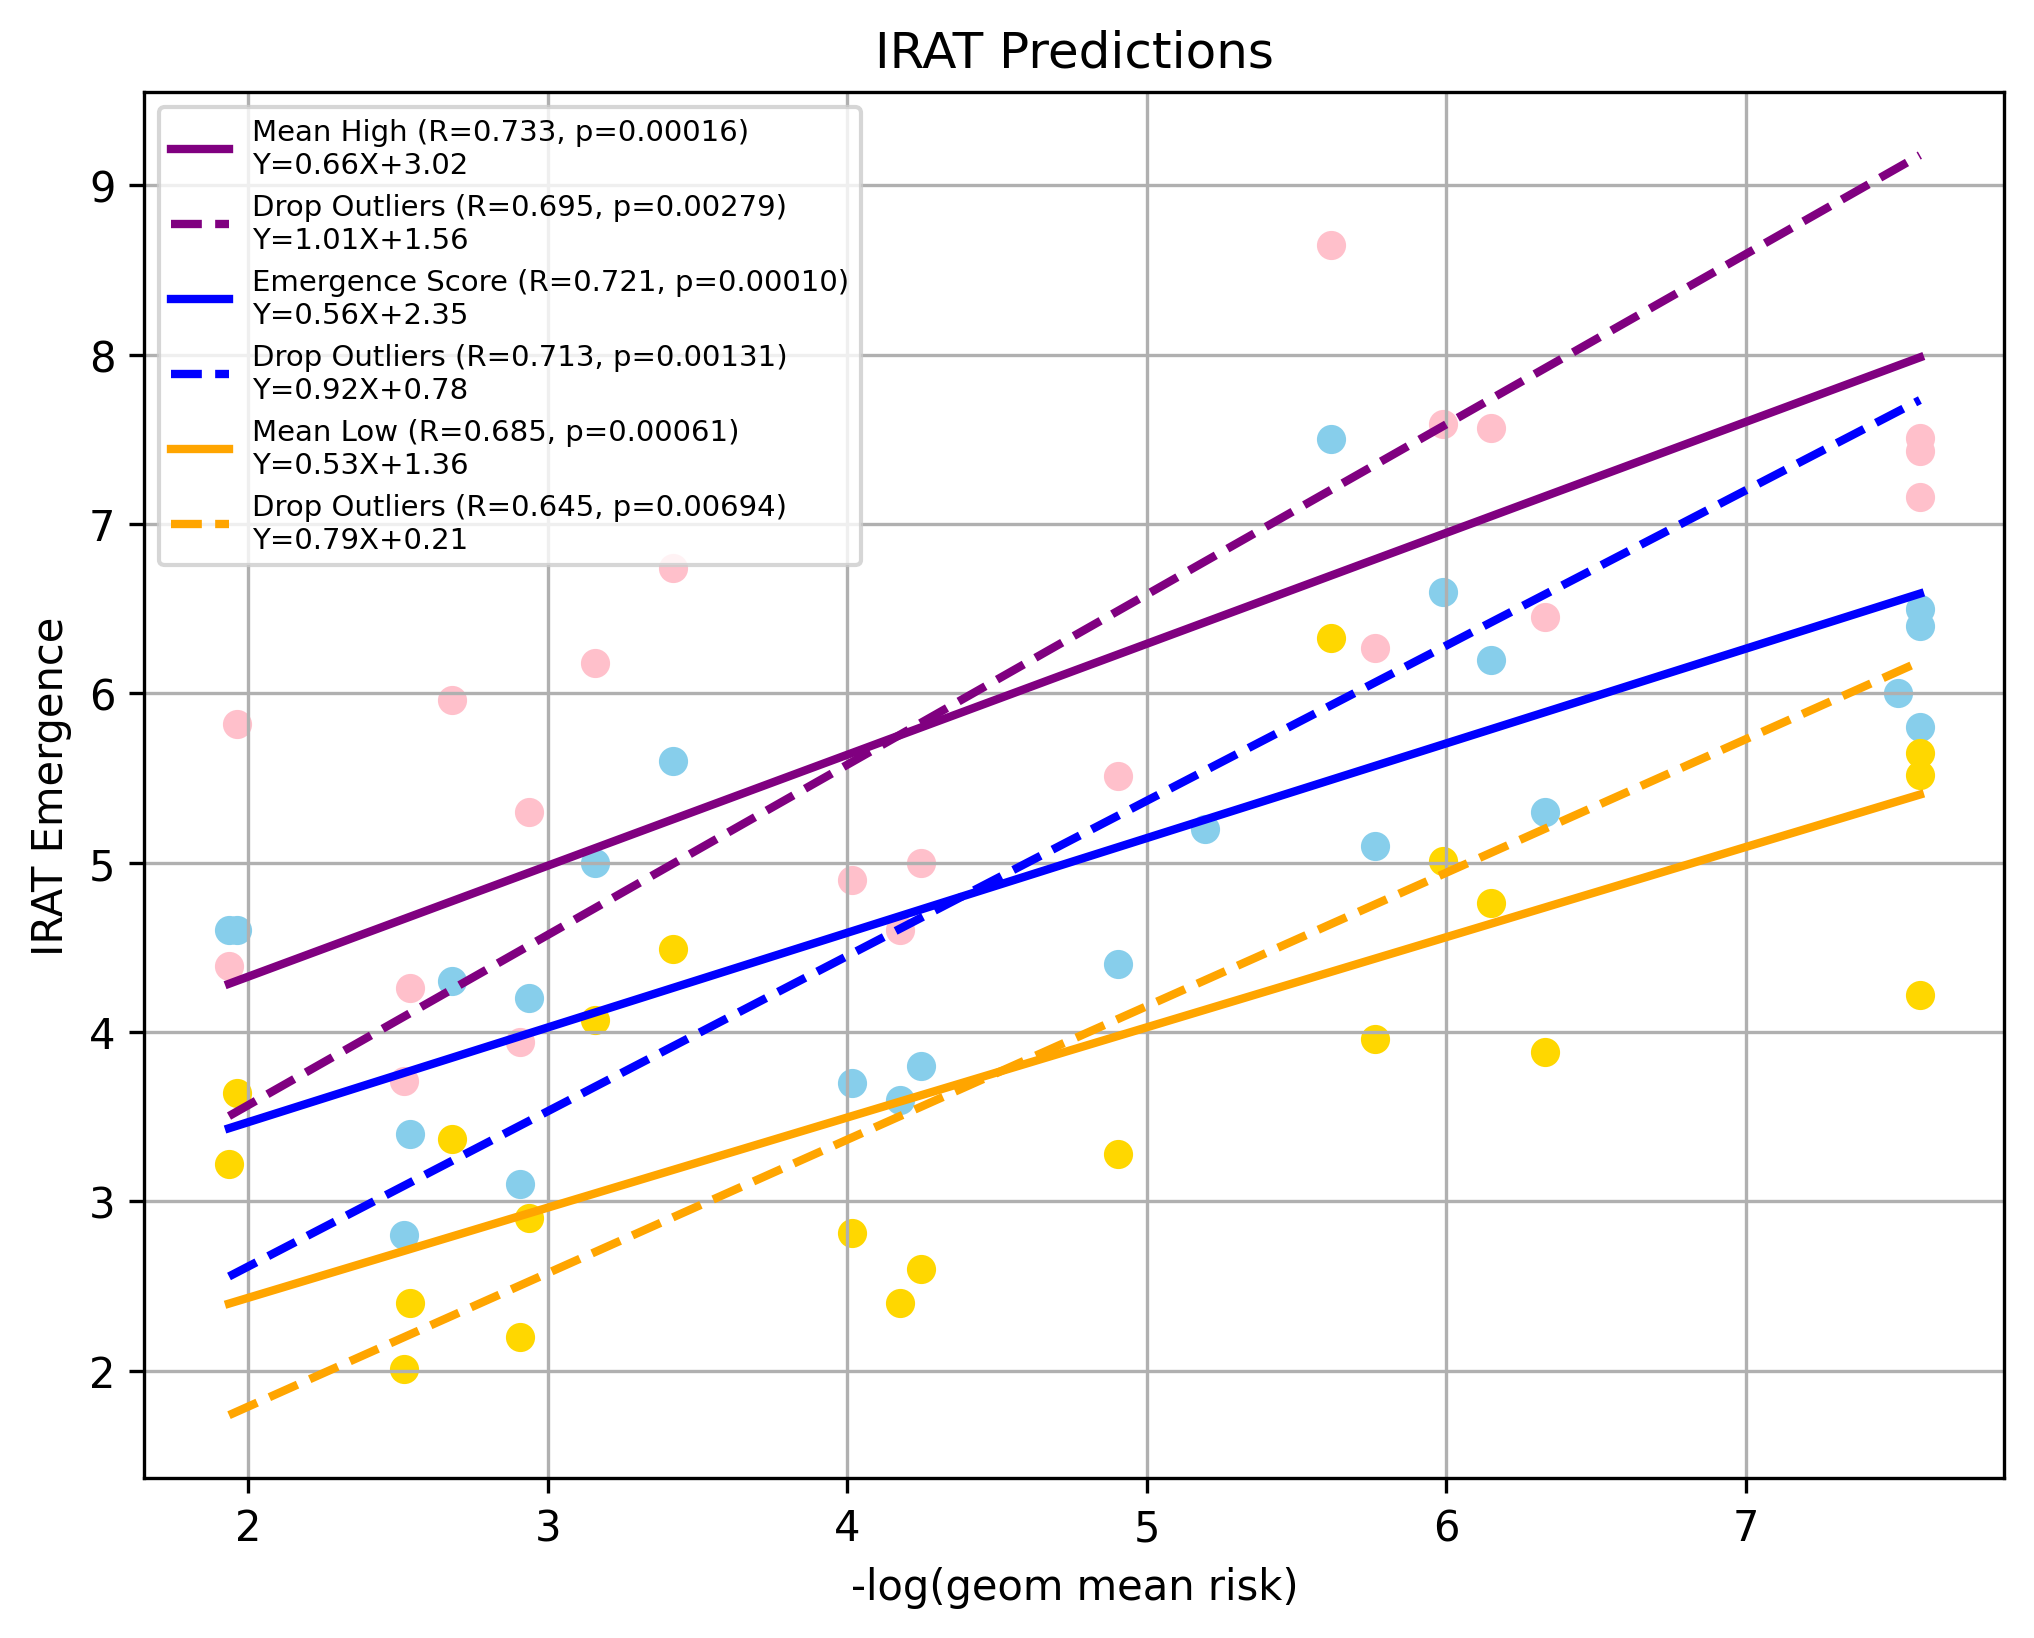

In [12]:
const = 5e-4
def save_model(slope, intercept, filepath):
    params = {'slope': slope, 'intercept': intercept}
    joblib.dump(params, filepath)

    
# Mean high emergence
X = (-np.log(irat[irat['Mean High Acceptable Emergence'] != -1]['Geom Mean Risk'] + const))
Y = irat[irat['Mean High Acceptable Emergence'] != -1]['Mean High Acceptable Emergence']
tls_slope, tls_intercept, tls_R, tls_p = TLS(X, Y)
X_line = np.linspace(min(X), max(X), 100)
Y_tls = tls_slope * X_line + tls_intercept
plt.scatter(X, Y, color='pink')
plt.plot(X_line, Y_tls, label=f'Mean High (R={tls_R:.3f}, p={tls_p:.5f})\nY={tls_slope:.2f}X+{tls_intercept:.2f}',
         color='purple', linewidth=2)
# Mean high emergence - drop outliers
X = (-np.log(irat[irat['Mean High Acceptable Emergence'] != -1]['Geom Mean Risk'] + const))[3:-2]
Y = irat[irat['Mean High Acceptable Emergence'] != -1]['Mean High Acceptable Emergence'][3:-2]
tls_slope, tls_intercept, tls_R, tls_p = TLS(X, Y)
save_model(tls_slope, tls_intercept, LINEAR_MODEL_DIR+'emergence_high_model.joblib')
save_model(tls_slope, tls_intercept, EMERGENET_MODEL_DIR+'emergence_high_model.joblib')
Y_tls = tls_slope * X_line + tls_intercept
plt.plot(X_line, Y_tls, label=f'Drop Outliers (R={tls_R:.3f}, p={tls_p:.5f})\nY={tls_slope:.2f}X+{tls_intercept:.2f}', 
         linestyle='--', color='purple', linewidth=2)


# IRAT emergence
X = -np.log(irat['Geom Mean Risk'] + const)
irat['-log(Geom Mean Risk)'] = X
irat.to_csv(RESULT_DIR + 'irat.csv', index=False)
Y = irat['Emergence Score']
tls_slope, tls_intercept, tls_R, tls_p = TLS(X, Y)
X_line = np.linspace(min(X), max(X), 100)
Y_tls = tls_slope * X_line + tls_intercept
plt.scatter(X, Y, color='skyblue')
plt.plot(X_line, Y_tls, label=f'Emergence Score (R={tls_R:.3f}, p={tls_p:.5f})\nY={tls_slope:.2f}X+{tls_intercept:.2f}', 
         color='blue', linewidth=2)
# IRAT emergence - drop outliers
X = -np.log(irat['Geom Mean Risk'] + const)[4:-2]
Y = irat['Emergence Score'][4:-2]
tls_slope, tls_intercept, tls_R, tls_p = TLS(X, Y)
save_model(tls_slope, tls_intercept, LINEAR_MODEL_DIR+'emergence_model.joblib')
save_model(tls_slope, tls_intercept, EMERGENET_MODEL_DIR+'emergence_model.joblib')
Y_tls = tls_slope * X_line + tls_intercept
plt.plot(X_line, Y_tls, label=f'Drop Outliers (R={tls_R:.3f}, p={tls_p:.5f})\nY={tls_slope:.2f}X+{tls_intercept:.2f}', 
         linestyle='--', color='blue', linewidth=2)


# Mean low emergence
X = (-np.log(irat[irat['Mean Low Acceptable Emergence'] != -1]['Geom Mean Risk'] + const))
Y = irat[irat['Mean Low Acceptable Emergence'] != -1]['Mean Low Acceptable Emergence']
tls_slope, tls_intercept, tls_R, tls_p = TLS(X, Y)
X_line = np.linspace(min(X), max(X), 100)
Y_tls = tls_slope * X_line + tls_intercept
plt.scatter(X, Y, color='gold')
plt.plot(X_line, Y_tls, label=f'Mean Low (R={tls_R:.3f}, p={tls_p:.5f})\nY={tls_slope:.2f}X+{tls_intercept:.2f}', 
         color='orange', linewidth=2)
# Mean low emergence - drop outliers
X = (-np.log(irat['Geom Mean Risk'] + const)).drop([3, 9])[3:-2]
Y = irat['Mean Low Acceptable Emergence'].drop([3, 9])[3:-2]
tls_slope, tls_intercept, tls_R, tls_p = TLS(X, Y)
save_model(tls_slope, tls_intercept, LINEAR_MODEL_DIR+'emergence_low_model.joblib')
save_model(tls_slope, tls_intercept, EMERGENET_MODEL_DIR+'emergence_low_model.joblib')
Y_tls = tls_slope * X_line + tls_intercept
plt.plot(X_line, Y_tls, label=f'Drop Outliers (R={tls_R:.3f}, p={tls_p:.5f})\nY={tls_slope:.2f}X+{tls_intercept:.2f}', 
         linestyle='--', color='orange', linewidth=2)


plt.xlabel('-log(geom mean risk)')
plt.ylabel('IRAT Emergence')
plt.legend(fontsize=7)
plt.grid()
plt.title('IRAT Predictions');

## Plots

In [18]:
from zedstat.ci import ci

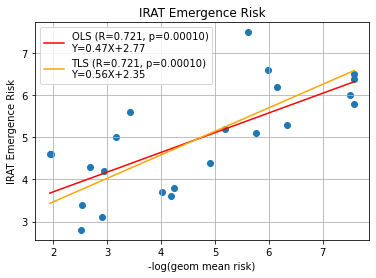

In [19]:
X = -np.log(irat['Geom Mean Risk'] + 5e-4)
Y = irat['Emergence Score']
ols_slope, ols_intercept, ols_R, ols_p, _ = linregress(X, Y)
tls_slope, tls_intercept, tls_R, tls_p = TLS(X, Y)

# Plot
X_line = np.linspace(min(X), max(X), 100)
Y_ols = ols_slope * X_line + ols_intercept
Y_tls = tls_slope * X_line + tls_intercept

plt.scatter(X, Y)
plt.plot(X_line, Y_ols, label=f'OLS (R={ols_R:.3f}, p={ols_p:.5f})\nY={ols_slope:.2f}X+{ols_intercept:.2f}',color='red')
plt.plot(X_line, Y_tls, label=f'TLS (R={tls_R:.3f}, p={tls_p:.5f})\nY={tls_slope:.2f}X+{tls_intercept:.2f}',color='orange')
plt.xlabel('-log(geom mean risk)')
plt.ylabel('IRAT Emergence Risk')
plt.legend()
plt.grid()
plt.title('IRAT Emergence Risk');

In [46]:
X = -np.log(irat['Geom Mean Risk'] + 5e-4).values
Y = irat['Emergence Score'].values
irat['logrisk']=X

aic:  61.702711243771354 p-value:  0.00010488095004259718 correlation:  0.7206831205067071


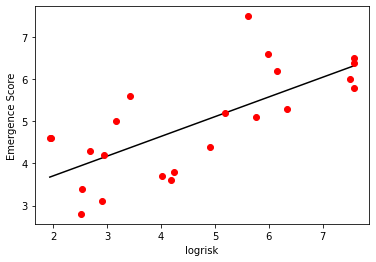

In [58]:
xvar='logrisk'
yvar='Emergence Score'
pred,pval,aic,corr,est=ci(irat,xvar,yvar,alpha=.05)
fig, ax = plt.subplots()
#plt.fill_between(pred.index,pred.ub,pred.lb,alpha=.2,color='g')
pred.pred.plot(style='-k')
irat.set_index(xvar)[yvar].plot(style='ro')
plt.gca().set_ylabel(yvar)
print('aic: ',aic,'p-value: ',pval,'correlation: ',corr)

pred=pred.rename(columns={'pred':'pred_GM','ub':'ub_GM','lb':'lb_GM'})
irat1=irat.join(pred,on=xvar)

In [59]:
pred

,pred_GM,lb_GM,ub_GM
1.935591,3.675351,3.001065,4.349636
1.963757,3.688564,3.019006,4.358122
2.520177,3.949586,3.369547,4.529625
2.540892,3.959304,3.382431,4.536177
2.681779,4.025395,3.469677,4.581114
2.905585,4.130385,3.606757,4.654012
2.935861,4.144587,3.625143,4.664032
3.157702,4.248655,3.758554,4.738757
3.419025,4.371245,3.912335,4.830154
4.017131,4.651822,4.246352,5.057293


In [50]:
irat1

,Influenza Virus,Virus Type,Date of Risk Assessment,Risk Score Category,Emergence Score,Impact Score,Mean Low Acceptable Emergence,Mean High Acceptable Emergence,Mean Low Acceptable Impact,Mean High Acceptable Impact,...,NA Sequence,HA Length,NA Length,HA Risk,NA Risk,Geom Mean Risk,logrisk,pred_GM,lb_GM,ub_GM
0,A/Hong Kong/125/2017,H7N9,2017-05-01,Moderate-High,6.5,7.5,5.65,7.51,6.74,8.50,...,MNPNQKILCTSATAITIGAIAVLIGIANLGLNIGLHLKPGCNCSHS...,560,449,0.000010,0.000010,0.000010,7.581100,6.323716,5.608703,7.038729
0,A/Hong Kong/125/2017,H7N9,2017-05-01,Moderate-High,6.5,7.5,5.65,7.51,6.74,8.50,...,MNPNQKILCTSATAITIGAIAVLIGIANLGLNIGLHLKPGCNCSHS...,560,449,0.000010,0.000010,0.000010,7.581100,6.323716,5.608703,7.038729
0,A/Hong Kong/125/2017,H7N9,2017-05-01,Moderate-High,6.5,7.5,5.65,7.51,6.74,8.50,...,MNPNQKILCTSATAITIGAIAVLIGIANLGLNIGLHLKPGCNCSHS...,560,449,0.000010,0.000010,0.000010,7.581100,6.323716,5.608703,7.038729
1,A/Shanghai/02/2013,H7N9,2016-04-01,Moderate-High,6.4,7.2,5.52,7.43,6.41,8.32,...,MNPNQKILCTSATAIIIGAIAVLIGMANLGLNIGLHLKPGCNCSHS...,560,449,0.000010,0.000010,0.000010,7.581100,6.323716,5.608703,7.038729
1,A/Shanghai/02/2013,H7N9,2016-04-01,Moderate-High,6.4,7.2,5.52,7.43,6.41,8.32,...,MNPNQKILCTSATAIIIGAIAVLIGMANLGLNIGLHLKPGCNCSHS...,560,449,0.000010,0.000010,0.000010,7.581100,6.323716,5.608703,7.038729
1,A/Shanghai/02/2013,H7N9,2016-04-01,Moderate-High,6.4,7.2,5.52,7.43,6.41,8.32,...,MNPNQKILCTSATAIIIGAIAVLIGMANLGLNIGLHLKPGCNCSHS...,560,449,0.000010,0.000010,0.000010,7.581100,6.323716,5.608703,7.038729
2,A/California/62/2018,H1N2,2019-07-01,Moderate,5.8,5.7,4.22,7.16,3.80,7.09,...,MNPNQKIITIGSISLTLAAMCFLMQTAILVTNVTLHFNQCECHYPP...,560,449,0.000010,0.000010,0.000010,7.581100,6.323716,5.608703,7.038729
2,A/California/62/2018,H1N2,2019-07-01,Moderate,5.8,5.7,4.22,7.16,3.80,7.09,...,MNPNQKIITIGSISLTLAAMCFLMQTAILVTNVTLHFNQCECHYPP...,560,449,0.000010,0.000010,0.000010,7.581100,6.323716,5.608703,7.038729
2,A/California/62/2018,H1N2,2019-07-01,Moderate,5.8,5.7,4.22,7.16,3.80,7.09,...,MNPNQKIITIGSISLTLAAMCFLMQTAILVTNVTLHFNQCECHYPP...,560,449,0.000010,0.000010,0.000010,7.581100,6.323716,5.608703,7.038729
3,A/Indiana/08/2011,H3N2,2012-12-01,Moderate,6.0,4.5,-1.00,-1.00,-1.00,-1.00,...,MNPNQKIITIGSVSLIIATICFLMQIAILVTTVTLHFKQHDYNSPP...,560,449,0.000058,0.000043,0.000050,7.506456,6.288700,5.586520,6.990879


In [61]:
est.params

array([2.76734565, 0.46911008])

In [64]:
est.rsquared_adj

0.49649769162058444

In [65]:
irat1['Influenza Virus']=[x.replace('_','\_') for x in irat1['Influenza Virus'].values]
irat1.drop_duplicates().to_csv(RESULT_DIR + 'irat1.csv', index=False,float_format='%1.5f')


In [67]:
irat1.drop_duplicates().replace('_','\_')

,Influenza Virus,Virus Type,Date of Risk Assessment,Risk Score Category,Emergence Score,Impact Score,Mean Low Acceptable Emergence,Mean High Acceptable Emergence,Mean Low Acceptable Impact,Mean High Acceptable Impact,...,NA Sequence,HA Length,NA Length,HA Risk,NA Risk,Geom Mean Risk,logrisk,pred_GM,lb_GM,ub_GM
0,A/Hong Kong/125/2017,H7N9,2017-05-01,Moderate-High,6.5,7.5,5.65,7.51,6.74,8.50,...,MNPNQKILCTSATAITIGAIAVLIGIANLGLNIGLHLKPGCNCSHS...,560,449,0.000010,0.000010,0.000010,7.581100,6.323716,5.608703,7.038729
1,A/Shanghai/02/2013,H7N9,2016-04-01,Moderate-High,6.4,7.2,5.52,7.43,6.41,8.32,...,MNPNQKILCTSATAIIIGAIAVLIGMANLGLNIGLHLKPGCNCSHS...,560,449,0.000010,0.000010,0.000010,7.581100,6.323716,5.608703,7.038729
2,A/California/62/2018,H1N2,2019-07-01,Moderate,5.8,5.7,4.22,7.16,3.80,7.09,...,MNPNQKIITIGSISLTLAAMCFLMQTAILVTNVTLHFNQCECHYPP...,560,449,0.000010,0.000010,0.000010,7.581100,6.323716,5.608703,7.038729
3,A/Indiana/08/2011,H3N2,2012-12-01,Moderate,6.0,4.5,-1.00,-1.00,-1.00,-1.00,...,MNPNQKIITIGSVSLIIATICFLMQIAILVTTVTLHFKQHDYNSPP...,560,449,0.000058,0.000043,0.000050,7.506456,6.288700,5.586520,6.990879
4,A/Sichuan/06681/2021,H5N6,2021-10-01,Moderate,5.3,6.3,3.88,6.45,5.04,7.47,...,MNPNQKITCISATGVTLSIVSLLIGITNLGLNIGLHYKVSDSTTIN...,560,449,0.000010,0.164745,0.001284,6.329162,5.736419,5.218715,6.254124
5,A/Anhui-Lujiang/39/2018,H9N2,2019-07-01,Moderate,6.2,5.9,4.76,7.57,4.30,7.30,...,MNPNQKITAIGSVSLIIAIICLLMQIAILTTTMTLHFGQKECSNPS...,560,449,0.000790,0.003381,0.001635,6.149484,5.652131,5.158270,6.145991
6,A/Ohio/13/2017,H3N2,2019-07-01,Moderate,6.6,5.8,5.01,7.59,4.09,7.26,...,MNPNQKIITIGSVSLIIATICFLMQIAILVTTITLHFKQHNCDSSP...,560,449,0.004091,0.000981,0.002003,5.990271,5.577442,5.103324,6.051560
7,A/mink/Spain/3691-8\_22VIR10586-10/2022,H5N1,2023-04-01,Moderate,5.1,6.2,3.96,6.27,4.95,7.43,...,MNPNQRIITTGSICMVIGIVSLMLQIGNIISIWVSHSIQTGNQYQP...,560,449,0.006426,0.001086,0.002642,5.762868,5.470765,5.022234,5.919296
8,A/swine/Shandong/1207/2016,H1N1,2020-07-01,Moderate,7.5,6.9,6.33,8.65,5.42,8.09,...,MNPNQKIITIGSICMTIGIASLILQIGNIISIWISHSIQIENQNQS...,560,449,0.002443,0.004053,0.003147,5.613976,5.400918,4.967245,5.834592
9,A/Vietnam/1203/2004,H5N1,2011-11-01,Moderate,5.2,6.6,-1.00,-1.00,-1.00,-1.00,...,MNPNQKIITIGSICMVTGIVSLMLQIGNMISIWVSHSIHTGNQHQS...,560,449,0.005610,0.004546,0.005050,5.193877,5.203846,4.802455,5.605237
